In [ ]:
# import libraries and packages
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [ ]:
# import dataset
# please download the dataset here: https://github.com/zhouhaoyi/ETDataset/tree/main/ETT-small
df = pd.read_csv("ETTh1.csv")
df.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


In [ ]:
df.tail()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
17415,2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904
17416,2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044
17417,2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,10.271
17418,2018-06-26 18:00:00,9.243,3.818,5.472,2.097,3.655,1.432,9.778
17419,2018-06-26 19:00:00,10.114,3.550,6.183,1.564,3.716,1.462,9.567


In [ ]:
len(df)

17420

In [ ]:
df["OT"].max()

46.00699996948242

In [ ]:
df_2 = pd.read_csv("ETTm1.csv")
df_2.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 00:15:00,5.760,2.076,1.492,0.426,4.264,1.401,30.459999
2,2016-07-01 00:30:00,5.760,1.942,1.492,0.391,4.234,1.310,30.038000
3,2016-07-01 00:45:00,5.760,1.942,1.492,0.426,4.234,1.310,27.013000
4,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001


In [ ]:
len(df_2)

69680

##DataLoader

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [ ]:
class Dataset_ETTh1(Dataset):
  def __init__(self, data, seq_len=None, label_len=None, gaussian_noise=None): 
    self.data = data

    # Use the data of the first 6 days to predict the OT of the seventh day as default
    if seq_len == None:
      self.seq_len = 24*6
    else:
      self.seq_len = seq_len

    if label_len == None:     
      self.label_len = 24
    else:
      self.label_len = label_len

    # the standard deviation of the noise added to the dataset
    if gaussian_noise == None:
      self.gaussian_noise = 0
    else:
      self.gaussian_noise = gaussian_noise

  def __len__(self):
    return len(self.data) - self.seq_len - self.label_len + 1

  def __getitem__(self, idx):
    # add random shift to the dataset
    noise_X = torch.randn(self.seq_len, self.data.shape[-1]) * self.gaussian_noise
    noise_y = torch.randn(self.label_len,) * self.gaussian_noise

    X = torch.Tensor(self.data[idx:idx+self.seq_len, :])
    y = torch.Tensor(self.data[idx+self.seq_len:idx+self.seq_len+self.label_len, -1]) # Only use row OT as label

    assert noise_X.shape == X.shape
    assert noise_y.shape == y.shape

    X = X + noise_X
    y = y + noise_y
    return X, y


In [ ]:
# Split the dataset in the ratio train:val:test = 6:2:2
train_idx = int(len(df) * 0.6)
val_idx = int(len(df) * 0.8)

df_data = df.drop(columns=['date'])

train_data = df_data[0:train_idx].values
val_data = df_data[train_idx:val_idx].values
test_data = df_data[val_idx:].values

# Normalize data
scaler = MinMaxScaler()
scaler.fit(train_data)

# Used to inverse_transform the labels back
label_scaler = MinMaxScaler()
label_scaler.fit(train_data[:,-1].reshape(-1, 1))

train_data_scaled = scaler.transform(train_data)
val_data_scaled = scaler.transform(val_data)
test_data_scaled = scaler.transform(test_data)

In [ ]:
train_set = Dataset_ETTh1(train_data_scaled)
val_set = Dataset_ETTh1(val_data_scaled)
test_set = Dataset_ETTh1(test_data_scaled)

train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_set, batch_size=32, shuffle=False)

In [ ]:
# The dataloader with noise added
train_noise_set = Dataset_ETTh1(train_data_scaled, gaussian_noise=0.05)
train_noise_dataloader = DataLoader(train_noise_set, batch_size=32, shuffle=True)

In [ ]:
len(train_dataloader)

322

##Neural Network


###RNN

####Model

In [ ]:
# Define RNN model
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
    self.fc = nn.Linear(hidden_size, output_size)
        
  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
    _, hidden = self.rnn(x, h0)
    out = self.fc(hidden[-1, :, :])
    return out

####Training

In [ ]:
from torch.nn.utils.rnn import pad_sequence

In [ ]:
def training(model, criterion, optimizer, train_loader, val_loader):
  # Train RNN model
  train_loss_list = []
  val_loss_list = []
  num_epochs = 5
  for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    for i, data in enumerate(train_loader):
      X, y = data
      optimizer.zero_grad()
      X_padded = pad_sequence(X, batch_first=True)
      y_pred = model(X_padded)
      loss = criterion(y_pred, y)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      if i % 50 == 0:
        train_loss_list.append(running_loss / (i+1))

        # set model to evaluation mode
        model.eval()  
        val_loss = 0.0
        
        with torch.no_grad():
          for j, data in enumerate(val_loader):
            X, y = data
            X_padded = pad_sequence(X, batch_first=True)
            y_pred = model(X_padded)
            loss = criterion(y_pred, y)
            val_loss += loss.item() * X.size(0)
          val_loss = val_loss / len(val_loader)
          val_loss_list.append(val_loss)
      
        print('Epoch: {}, {} / {}, Training Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch+1, i, len(train_dataloader), running_loss / (i+1), val_loss))
  return train_loss_list, val_loss_list

Train Vanilla RNN without data shifting

In [ ]:
input_size = 7  
hidden_size = 128  
output_size = 24
num_layers = 2
dropout = 0.5
RNN_model = RNN(input_size, hidden_size, output_size, num_layers, dropout)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(RNN_model.parameters(), lr=0.0005)

train_loss_list, val_loss_list = training(RNN_model, criterion, optimizer, train_dataloader, val_dataloader)

Epoch: 1, 0 / 322, Training Loss: 0.2523, Validation Loss: 1.7662
Epoch: 1, 50 / 322, Training Loss: 0.0495, Validation Loss: 1.0556
Epoch: 1, 100 / 322, Training Loss: 0.0291, Validation Loss: 0.0760
Epoch: 1, 150 / 322, Training Loss: 0.0211, Validation Loss: 0.2650
Epoch: 1, 200 / 322, Training Loss: 0.0169, Validation Loss: 0.0655
Epoch: 1, 250 / 322, Training Loss: 0.0142, Validation Loss: 0.0519
Epoch: 1, 300 / 322, Training Loss: 0.0125, Validation Loss: 0.0594
Epoch: 2, 0 / 322, Training Loss: 0.0066, Validation Loss: 0.0589
Epoch: 2, 50 / 322, Training Loss: 0.0035, Validation Loss: 0.0642
Epoch: 2, 100 / 322, Training Loss: 0.0036, Validation Loss: 0.1502
Epoch: 2, 150 / 322, Training Loss: 0.0036, Validation Loss: 0.0629
Epoch: 2, 200 / 322, Training Loss: 0.0036, Validation Loss: 0.0854
Epoch: 2, 250 / 322, Training Loss: 0.0035, Validation Loss: 0.0503
Epoch: 2, 300 / 322, Training Loss: 0.0035, Validation Loss: 0.0544
Epoch: 3, 0 / 322, Training Loss: 0.0071, Validation L

Plotting the loss trending

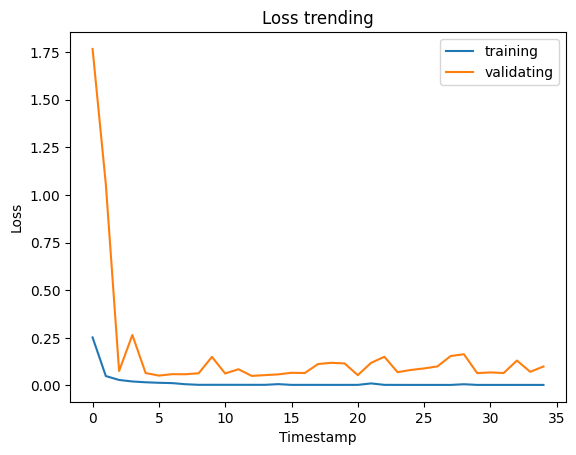

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_loss_list)), train_loss_list, label="training")
plt.plot(range(len(val_loss_list)), val_loss_list, label="validating")

plt.xlabel('Timestamp')
plt.ylabel('Loss')
plt.title('Loss trending')
plt.legend(loc="upper right")

plt.show()

####Testing

In [ ]:
def testing(model, criterion, test_loader):
  model.eval()  # set model to evaluation mode
  test_loss = 0.0
  y_pred_list = []
  y_gt_list = []
  with torch.no_grad():
    for x, y in test_loader:
      x_padded = pad_sequence(x, batch_first=True)
      y_pred = model(x_padded)
      loss = criterion(y_pred, y)
      test_loss += loss.item() * x.size(0)

      # y_pred = label_scaler.inverse_transform(y_pred.numpy())
      # y = label_scaler.inverse_transform(y.numpy())

      y_pred_list.append(y_pred)
      y_gt_list.append(y)
    test_loss = test_loss / len(test_loader)

  print('Test Loss: {:.4f}'.format(test_loss))
  return y_pred_list, y_gt_list

In [ ]:
y_pred_list, y_gt_list = testing(RNN_model, criterion, test_dataloader)

Test Loss: 0.0727


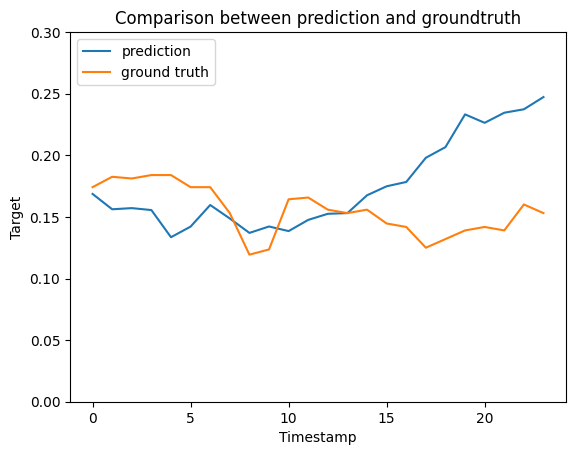

In [ ]:
plt.plot(range(24), y_pred_list[0][0], label="prediction")
plt.plot(range(24), y_gt_list[0][0], label="ground truth")

plt.xlabel('Timestamp')
plt.ylabel('Target')
plt.ylim([0, 0.3])
plt.title('Comparison between prediction and groundtruth')
plt.legend(loc="upper left")

### Adding Data Shifting

In [ ]:
input_size = 7  
hidden_size = 128  
output_size = 24
num_layers = 2 
dropout = 0.5
RNN_model_2 = RNN(input_size, hidden_size, output_size, num_layers, dropout)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(RNN_model_2.parameters(), lr=0.0005)

train_loss_list, val_loss_list = training(RNN_model_2, criterion, optimizer, train_noise_dataloader, val_dataloader)

Epoch: 1, 0 / 322, Training Loss: 0.2123, Validation Loss: 1.4837
Epoch: 1, 50 / 322, Training Loss: 0.0464, Validation Loss: 1.9306
Epoch: 1, 100 / 322, Training Loss: 0.0291, Validation Loss: 0.2689
Epoch: 1, 150 / 322, Training Loss: 0.0220, Validation Loss: 0.0686
Epoch: 1, 200 / 322, Training Loss: 0.0184, Validation Loss: 0.0635
Epoch: 1, 250 / 322, Training Loss: 0.0160, Validation Loss: 0.0534
Epoch: 1, 300 / 322, Training Loss: 0.0145, Validation Loss: 0.0584
Epoch: 2, 0 / 322, Training Loss: 0.0085, Validation Loss: 0.0546
Epoch: 2, 50 / 322, Training Loss: 0.0067, Validation Loss: 0.0659
Epoch: 2, 100 / 322, Training Loss: 0.0069, Validation Loss: 0.1295
Epoch: 2, 150 / 322, Training Loss: 0.0068, Validation Loss: 0.0565
Epoch: 2, 200 / 322, Training Loss: 0.0067, Validation Loss: 0.0513
Epoch: 2, 250 / 322, Training Loss: 0.0065, Validation Loss: 0.0626
Epoch: 2, 300 / 322, Training Loss: 0.0065, Validation Loss: 0.0531
Epoch: 3, 0 / 322, Training Loss: 0.0099, Validation L

In [ ]:
y_pred_list, y_gt_list = testing(RNN_model_2, criterion, test_dataloader)

Test Loss: 0.1179


##Linear Regression

**Data Preprocess**

In [ ]:
X = []
y = []
lr_train_dataloader = DataLoader(train_set, batch_size=1, shuffle=True)
for batch in lr_train_dataloader:
  X_batch, y_batch = batch
  X.append(X_batch.numpy().reshape([1, -1]))
  y.append(y_batch.numpy().reshape([1, -1]))
x_train = np.concatenate(X)
y_train = np.concatenate(y)

In [ ]:
x_train.shape

(10285, 1008)

In [ ]:
X = []
y = []
lr_test_dataloader = DataLoader(test_set, batch_size=1, shuffle=False)
for batch in lr_test_dataloader:
  X_batch, y_batch = batch
  X.append(X_batch.numpy().reshape([1, -1]))
  y.append(y_batch.numpy())

x_test = np.concatenate(X)
y_test = np.concatenate(y)

In [ ]:
x_test.shape

(3317, 1008)

**Linear Regression without Regularization**

In [ ]:
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn import metrics

In [ ]:
reg = LinearRegression() 
reg.fit(x_train, y_train) 
y_train_pred = reg.predict(x_train) 
y_test_pred = reg.predict(x_test) 

train_r2 = metrics.r2_score(y_train, y_train_pred)
train_mse = metrics.mean_squared_error(y_train, y_train_pred)

test_r2 = metrics.r2_score(y_test, y_test_pred)
test_mse = metrics.mean_squared_error(y_test, y_test_pred)

In [ ]:
print("The R2 of training data is " + str(train_r2))
print("The R2 of testing data is " + str(test_r2))
print("The MSE of training data is " + str(train_mse))
print("The MSE of testing data is " + str(test_mse))
print('Training Accuracy: {}'.format(reg.score(x_train, y_train)))
print('Test Accuracy: {}'.format(reg.score(x_test, y_test)))

The R2 of training data is 0.9250185966325354
The R2 of testing data is 0.6535817997273295
The MSE of training data is 0.0021519356
The MSE of testing data is 0.0015625566
Training Accuracy: 0.9250185966325354
Test Accuracy: 0.6535817997273295


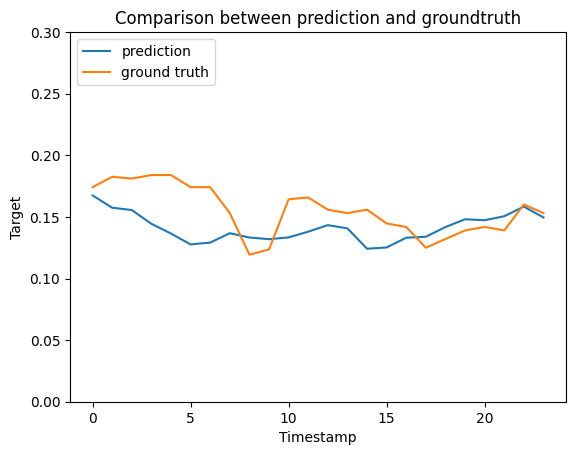

In [ ]:
plt.plot(range(24), y_test_pred[0], label="prediction")
plt.plot(range(24), y_test[0], label="ground truth")

plt.xlabel('Timestamp')
plt.ylabel('Target')
plt.ylim([0, 0.3])
plt.title('Comparison between prediction and groundtruth')
plt.legend(loc="upper left")

**Linear Regression With Ridge Regularization**

In [ ]:
ridge = Ridge() 
ridge.fit(x_train, y_train) 
y_train_pred = ridge.predict(x_train) 
y_test_pred = ridge.predict(x_test) 

train_r2 = metrics.r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

test_r2 = metrics.r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

In [ ]:
print("The R2 of training data is " + str(train_r2))
print("The R2 of testing data is " + str(test_r2))
print("The RMSE of training data is " + str(train_rmse))
print("The RMSE of testing data is " + str(test_rmse))
print('Training Accuracy: {}'.format(ridge.score(x_train, y_train)))
print('Test Accuracy: {}'.format(ridge.score(x_test, y_test)))

The R2 of training data is 0.9245586973098862
The R2 of testing data is 0.6608908058761013
The RMSE of training data is 0.046531145
The RMSE of testing data is 0.03911027
Training Accuracy: 0.9245586973098862
Test Accuracy: 0.6608908058761013


## Classification

In [ ]:
df

In [ ]:
for i in range(10):
  print("The " + str(10*i) + " percent quantile of price is " + str(round(df['OT'].quantile(i/10),2)))

The 0 percent quantile of price is -4.08
The 10 percent quantile of price is 4.01
The 20 percent quantile of price is 6.05
The 30 percent quantile of price is 8.02
The 40 percent quantile of price is 9.78
The 50 percent quantile of price is 11.4
The 60 percent quantile of price is 13.79
The 70 percent quantile of price is 16.6
The 80 percent quantile of price is 19.77
The 90 percent quantile of price is 24.62


In [ ]:
df["OT"].max()

46.00699996948242

In [ ]:
#divide oil temperature into groups by percentile
c1 = df['OT'].quantile(0.25)
c2 = df['OT'].quantile(0.50)
c3 = df['OT'].quantile(0.75)
def divide_OT(x):
  if x < c1:
    return 0
  elif x < c2:
    return 1
  elif x < c3:
    return 2
  else:
    return 3
df["OT_group"] = df["OT"].apply(divide_OT).astype("float")

In [ ]:
features = df.drop(columns = ["date","OT","OT_group"])
OT_group = df["OT_group"]
seed = 42
random_state = seed
x_train, x_test, y_train, y_test = train_test_split(features, OT_group, test_size = 0.20, random_state=seed)

In [ ]:
#Standarization and PCA
scaler = StandardScaler()
scaler.fit(x_train)
scaled_x_train = scaler.transform(x_train)
scaled_x_test = scaler.transform(x_test)

pca = PCA(n_components=scaled_x_train.shape[1])
pca_x_train = pca.fit_transform(scaled_x_train)

In [ ]:
explained_variance_ratios =pca.explained_variance_ratio_
cum_evr = np.cumsum(pca.explained_variance_ratio_)

In [ ]:
plt.figure(figsize=(15,10))
n = scaled_x_train.shape[1]
p = plt.plot(np.arange(1,7),cum_evr)
plt.plot(np.arange(1,13), [0.95]*12)
plt.title('explained_variance_ratio v.s number of component')
plt.xlabel('number of component')
plt.ylabel('explained_variance_ratio')

In [ ]:
pca = PCA(n_components = 4)
x_train_pca = pca.fit_transform(scaled_x_train)
x_test_pca = pca.transform(scaled_x_test)

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
log_reg_pca=LogisticRegression(penalty="l2",solver='liblinear')
log_reg_pca.fit(x_train_pca,y_train)
y_pred = log_reg_pca.predict(x_test_pca)
acc_reg_train = log_reg_pca.score(x_train_pca,y_train)
acc_reg_test = log_reg_pca.score(x_test_pca,y_test)

In [ ]:
print('Train Accuracy: '+ str(acc_reg_train))
print('Test Accuracy: '+ str(acc_reg_test))

Train Accuracy: 0.35376004592422505
Test Accuracy: 0.3567738231917336


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(n_estimators = 15, max_depth = 15)
rf.fit(x_train, y_train)
train_pred_rf = rf.predict(x_train) 
test_pred_rf = rf.predict(x_test)

In [ ]:
acc_rf_train=rf.score(x_train,y_train)
acc_rf_test=rf.score(x_test,y_test)
print('Train Accuracy: '+ str(acc_rf_train))
print('Test Accuracy: ' + str(acc_rf_test))

Train Accuracy: 0.8987514351320322
Test Accuracy: 0.5315729047072331


## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [ ]:
KNN = KNeighborsClassifier(n_neighbors=15, p = 2)
KNN.fit(x_train, y_train)
y_test = KNN.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.40470723306544204
